# [IAPR][iapr]: Project


**Group ID:** 49

**Author 1 (sciper):** Mariane Brodier (250488)  
**Author 2 (sciper):** Lucas Bost (270139)   
**Author 3 (sciper):** Nicolas Delamaide (271789)    

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
The functions in this notebook that are used in our final pipeline can be found in the file `extraction.py`. We used this notebook to investigate how to process the images of the games to extract useful information for the tasks we had to complete.


## Import image

First, we import the image of a game.

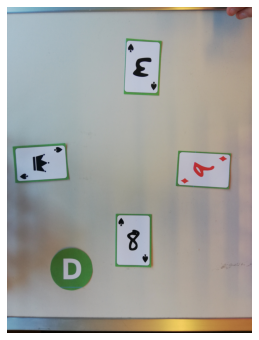

In [1]:
import os
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_base_path = os.path.join(os.pardir, 'project/train_games')
data_folder = 'game1'

# Load image
data_path = os.path.join(data_base_path, data_folder)
image1 = skimage.io.imread(os.path.join(data_path, '6.jpg'))

# Display image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(image1)
ax.axis('off')
plt.show()

## Plot image channels

Now that we have our image, let's decompose it into its RGB channels and greyscale. In our further studies, we will need our image to be binarized.

In [2]:
def crop(image, top=100, bottom=4400):
    return image[top:bottom, :, :]

In [3]:
image_cropped = crop(image1)
print(image_cropped.shape)

(4300, 3456, 3)


In [4]:
def decompose_channels(image):
    # Decompose image into greyscale and RGB channels
    
    gray = skimage.color.rgb2gray(image)
    red = image[:, :, 0]
    green = image[:, :,1]
    blue = image[:, :,2]
    
    return [gray, red, green, blue]

In [5]:
def plot_channels(images):
    # Plot the 4 channels of an image
    # Greyscale and RGB
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 12))

    axes[0].imshow(images[0], cmap='gray')
    axes[0].set_title('Grayscale')
    axes[1].imshow(images[1], cmap='gray')
    axes[1].set_title('Red channel')
    axes[2].imshow(images[2], cmap='gray')
    axes[2].set_title('Green channel')
    axes[3].imshow(images[3], cmap='gray')
    axes[3].set_title('Blue channel')

    for i in range(4):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

---
## Pre-processing

Let's check in which channel we can better see the contours of the cards and the token. We also have to binarize our image for the following of the project. Then we will perform the bounding boxes algorithm that we found on the scikit website :

https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py. 

First, we close small holes with binary closing, then we remove artifacts touching the image border, and finally we measure the image regions to filter small objects.

This algorithm helps us find the bounding boxes of the objects (here the cards and dealer token). It will return the number of boxes in the image and a dictionary of tuples (list_bbox_bounds, bbox_area, bbox_center).

To get the right number of bounding boxes, we must remove the boxes that are inside others or overlaping. To do so, we remove a box if the center is closer than the threshold of another center.

By doing so, we managed to extract the cards and the token, and we defined the players order. We plotted the boxes and the name of the players on the original image.

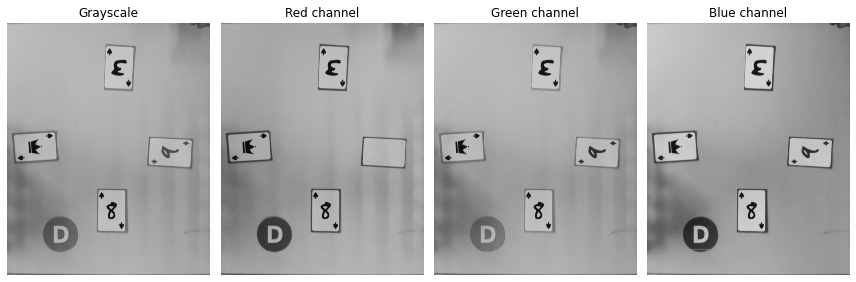

In [6]:
images = decompose_channels(image_cropped)

plot_channels(images)

In [7]:
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_multiotsu, threshold_otsu

def norm_binary(image):
    # Normalizes the image and returns the binary version
    
    # Contrast stretching
    a, b = np.percentile(image, (0, 50))
    norm_im = rescale_intensity(image, in_range=(a,b))
    
    # Apply otsu method for threshold
    #threshold = threshold_otsu(norm_im)
    #binary = norm_im > threshold
    
    # Apply multiotsu
    threshold = threshold_multiotsu(norm_im)
    digitized = np.digitize(norm_im, bins=threshold)
    
    return digitized

In [8]:
# Normalize the 4 channels
binaries = [] 

for i in range(len(images)):
    binaries.append(norm_binary(images[i]))

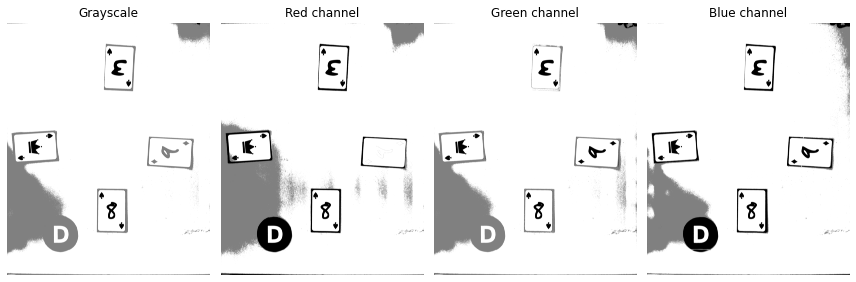

In [9]:
plot_channels(binaries)

We can see that the blue channel seems to be the best channel to find the bounding boxes of the cards and the dealer token.

In [10]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, binary_erosion
from skimage.color import label2rgb
import matplotlib.patches as mpatches


def find_bbox(image, threshold=25000, plot=True):
    # Finds the bboxes of the objects (here the cards and dealer token)
    # Returns the number of bboxes 
    # and a dictionary of tuples (list_bbox_bounds, bbox_area, bbox_center)
    
    closed = closing(image, square(2))
    
    cleared = clear_border(closed)

    # label image regions
    label_image = label(cleared, background=0, connectivity=1)
    
    # Store bboxes
    bboxes = {}
    num = 0

    for region in regionprops(label_image):
        
        # take regions with large enough area
        if  region.area >= threshold:
            
            # Compute area of bbox
            minr, minc, maxr, maxc = region.bbox

            c = maxc - minc
            r = maxr - minr
            area = c * r
            
            # Compute bbox center
            xc = (minr + maxr) // 2
            yc = (minc + maxc) // 2
            
            bboxes[num] = ([minr, minc, maxr, maxc], area, [xc, yc])
            num += 1
    
    if plot:
        # Plot overlay of image regions and bboxes
        plot_overlays(image, label_image, threshold)
    
    return num, bboxes

def plot_overlays(image, label_image, threshold=25000):
    # Plot overlay of image regions and bboxes
    
    # plot label and image
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        
        if region.area >= threshold: # 25000
            
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def get_centers(bboxes):
    # Get the centers of the bboxes of the cards only
    
    x_centers = []
    y_centers = []
    
    for i in range(len(bboxes.keys())):
        if bboxes[i][1] >= 200000: # Check if it's a card
            
            xc, yc = bboxes[i][2]
            
            x_centers.append(xc)
            y_centers.append(yc)
            
    return np.array(x_centers), np.array(y_centers)


def compute_distance(x1, y1, x2, y2):
    return np.sqrt(np.power(x1 - x2, 2)+np.power(y1 - y2, 2))

def remove_dup_bboxes(num, bboxes, threshold):
    # Remove bboxes inside others or overlaping
    # Remove a bbox if center is closer than threshold of another center
    # Only works if two overlapping bboxes
    
    # Keeps track of compared bboxes
    compared = np.zeros((num, num))
    
    # Index of bboxes to remove
    idx_remove = []
    
    for i in range(num):
        if bboxes[i][1] >= 200000: # Check if it's a card
            
            # Get first bbox center
            x1, y1 = bboxes[i][2]
            
            for j in range(num):
                
                # Compare only if never compared before
                if ((compared[i][j]==0) & (compared[j][i]==0) 
                     & (i!=j) & (bboxes[j][1] >= 200000)):
                    
                    # Get second bbox center
                    x2, y2 = bboxes[j][2]
                    
                    # Check if centers are too close
                    if compute_distance(x1, y1, x2, y2) <= threshold:
                        
                        # Record one with smaller area to remove later
                        area_i = bboxes[i][1]
                        area_j = bboxes[j][1]
                        
                        if area_i > area_j:
                            idx_remove.append(j)
                        else:
                            idx_remove.append(i)
                    
                    # Record that we compared i and j
                    compared[i][j] = 1
                    compared[j][i] = 1
    
    # Keep non overlaping bboxes
    bbox_filtered = {} 
    idx = 0
    for i in range(num):
        if i not in idx_remove:
            bbox_filtered[idx] = bboxes[i]
            idx += 1
    
    return idx, bbox_filtered
    
def rearrange_boxes(bboxes):
    
    # 0: Player1, 1: Player2 etc... 4: Dealer token
    boxes = {0: None, 1: None, 2: None, 3: None, 4: None}
    
    # If we have 1 dealer token and 4 cards
    if len(bboxes.keys()) == 5:
        xc, yc = get_centers(bboxes)
    
        min_x = np.min(xc)
        max_x = np.max(xc)
        min_y = np.min(yc)
        max_y = np.max(yc)
    
        for i in range(len(bboxes.keys())):
        
            # Check for dealer
            if bboxes[i][1] < 200000:
                boxes[4] = bboxes[i]
                
            else:
                
                x1, y1, x2, y2 = bboxes[i][0]
                x_c, y_c = bboxes[i][2]
                
                if x_c == min_x:
                    boxes[2] = bboxes[i]
                if x_c == max_x:
                    boxes[0] = bboxes[i]
                if y_c == min_y:
                    boxes[3] = bboxes[i]
                if y_c == max_y:
                    boxes[1] = bboxes[i]
                    
    # We have found less than 4 cards                
    else:
        
        # Dimensions of image
        height = 4300
        width = 3456
        
        # Divide height in 3 zones
        height_lim1 = height // 3
        height_lim2 = 2 * height_lim1
        
        # Divide width in 3 zones
        width_lim1 = width // 3
        width_lim2 = 2 * width_lim1
        
        # Go through each bbox and find it's position
        for i in range(len(bboxes.keys())):
            
            # Check for dealer
            if bboxes[i][1] < 200000:
                boxes[4] = bboxes[i]
                
            else:
                
                # Get centers
                x_c, y_c = bboxes[i][2]
                
                # If it's in top part, player 3
                if x_c < height_lim1:
                    boxes[2] = bboxes[i]
                    
                elif x_c > height_lim2: # If it's in bottom part, player1
                    boxes[0] = bboxes[i]
                    
                else: # It's either player 2 or player 4
                    
                    if y_c < width_lim1: # Player 4
                        boxes[3] = bboxes[i]
                        
                    else: # Player 2
                        boxes[1] = bboxes[i]
    return boxes

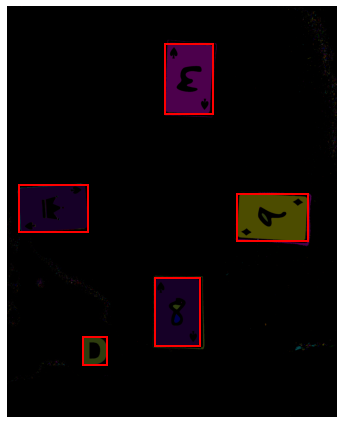

In [11]:
num, bboxes = find_bbox(binaries[3])

We can try another function too :

In [12]:
def find_robust_bbox(images):
    
    bin1 = images[1] == 2
    #Set all the borders to False to detect the cards at the edges of the image
    bin1[0:50,:] = False
    bin1[4250:4300,:] = False
    bin1[:, 0:50] = False
    bin1[:, 3406:3456] = False
    
    bin2 = images[1] == 2
    bin2[0:30,:] = False
    bin2[4270:4300,:] = False
    bin2[:, 0:30] = False
    bin2[:, 3426:3456] = False
    
    num, bboxes = find_bbox(bin1)
    
    if num == 5:
        return num, bboxes
    
    else:
        num, bboxes = find_bbox(bin2, plot=False)
        
        if num == 5:
            return num, bboxes
        
        else:
            num, bboxes = find_bbox(images[3], plot=False)
            
            return num, bboxes

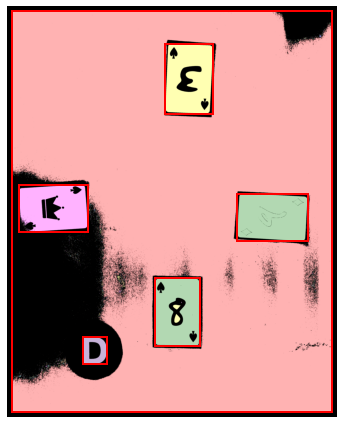

In [13]:
num2, bboxes2 = find_robust_bbox(binaries)

There are multiple bboxes for some of the cards, we need to remove them.

In [14]:
threshold = 100
num, bboxes = remove_dup_bboxes(num, bboxes, threshold)

boxes = rearrange_boxes(bboxes)

Now that we got the bounding boxes, we need to overlay them over the original image.

In [15]:
def plot_bbox(image, bboxes):
    # Plot the bboxes and class labels over the image
    
    # Display image
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image)
    ax.axis('off')
    
    # Labels
    labels = {0: 'Player 1', 1: 'Player 2', 2: 'Player 3', 3: 'Player 4',
              4: 'Dealer'}

    for i in range(len(bboxes.keys())):
        
        if bboxes[i] != None:
            
            # Get bbox bounds
            minr, minc, maxr, maxc = bboxes[i][0]
        
            # Draw rectangle
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        
            
            ax.text(minc, minr - 50, labels[i])
        
    plt.show()

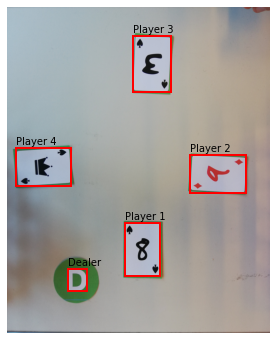

In [16]:
plot_bbox(image_cropped, boxes)

---
## CARD EXTRACTION

Now that we know where are the cards on the image, we extract them, we rotate them, we binarize them and we perform again the bounding box algorithm in order to detect the rank and the suites of each cards of the game.

The dealer token is found by calculating the distances between the bounding boxes : if two boxes are close, it means the smaller box is the token.

In [17]:
def extract_cards(img, bboxes):
    
    # 0: Player1, 1: Player2 etc...
    # We have to use empty arrays instead of None because images are arrays
    cards = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    
    for i in range(4):
        if bboxes[i] != None:
            x01, y01, x11, y11 = bboxes[i][0]
            cards[i] = img[x01:x11, y01:y11, :]
            
    return cards

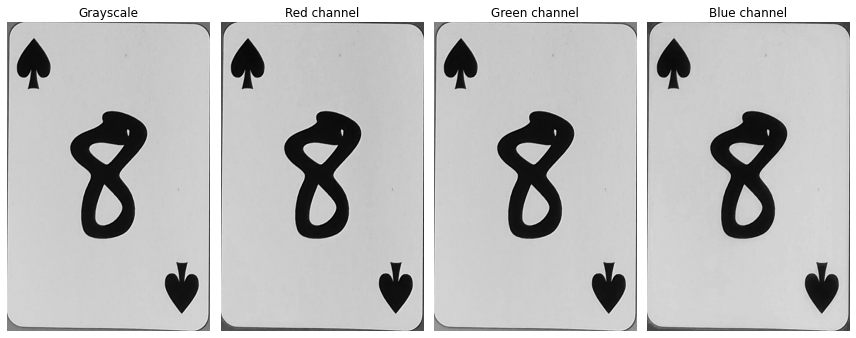

In [18]:
cards = extract_cards(image_cropped, boxes)

plot_channels(decompose_channels(cards[0]))

We will try to deblur or denoise image to see which one gives the best results for some of the blurry images.

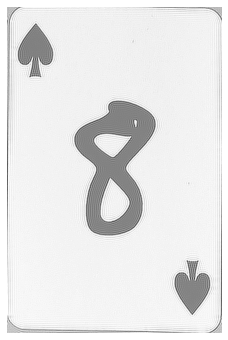

In [19]:
from skimage.restoration import unsupervised_wiener, richardson_lucy

# Kernel
psf = np.ones((4, 4)) / 20

# Denoise
deconvolved, _ = unsupervised_wiener(skimage.color.rgb2gray(cards[0]), psf)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(deconvolved, cmap='gray')
ax.axis('off')
plt.show()

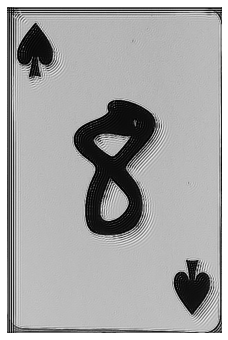

In [20]:
# Deblur
deconvolved_RL = richardson_lucy(skimage.color.rgb2gray(cards[0]), psf, iterations=40)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(deconvolved_RL, cmap='gray')
ax.axis('off')
plt.show()

The deblur / denoise algorithms don't seem to work well on the whole image (when we imported a blurred image).

In [21]:
def find_distances(bboxes):
    distances = []
    
    x_center_dealer, y_center_dealer = bboxes[4][2]
    
    # Find distances of cards from dealer token
    for i in range(4):
        
        if bboxes[i] != None:
            x_center_p, y_center_p = bboxes[i][2]
            dist = compute_distance(x_center_p, y_center_p, x_center_dealer, y_center_dealer)
            distances.append(dist)
        
    return distances

def find_dealer(distances):
    return np.argmin(np.array(distances)) + 1

In [22]:
distances = find_distances(boxes)
dealer = find_dealer(distances)

In [23]:
import imutils

def rotate_cards(cards):
    
    # 0: Player1, 1: Player2 etc...
    # We have to use empty arrays instead of None because images are arrays
    cards_rotated = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    rotations = [0, 90, 180, -90]

    for i in range(4):
        if cards[i].size != 0:
            cards_rotated[i] = imutils.rotate_bound(cards[i], rotations[i])

    return cards_rotated

In [24]:
cards_rotated = rotate_cards(cards)

In [25]:
def plot_cards(cards, cmap='viridis'):

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    
    for i in range(4):
        if cards[i].size!=0:
            ax[i].imshow(cards[i], cmap=cmap)
        ax[i].axis('off')

    plt.show()

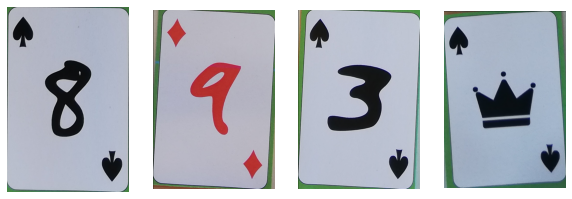

In [26]:
plot_cards(cards_rotated)

In [27]:
def binarize_cards(cards, channel=2):
    
    bin_cards = cards
    
    for i in range(len(cards)):
        
        if cards[i].size!=0:
        
            #Normalizes card
            norm = rescale_intensity(cards[i][:, :, channel])
        
            #Digitizes card
            th = threshold_multiotsu(norm)
            dig = np.digitize(norm, bins=th)
            bin_cards[i] = dig == 0 
        
    return bin_cards

In [28]:
bin_cards = binarize_cards(cards_rotated)

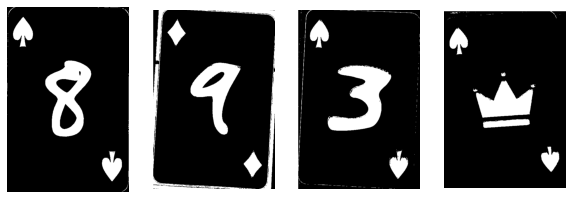

In [29]:
#Plot cards
plot_cards(bin_cards, 'gray')

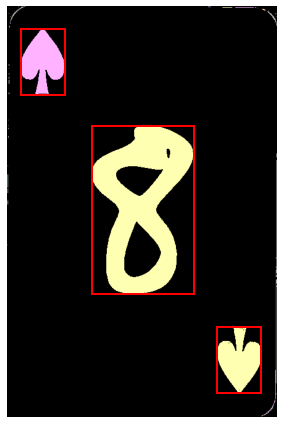

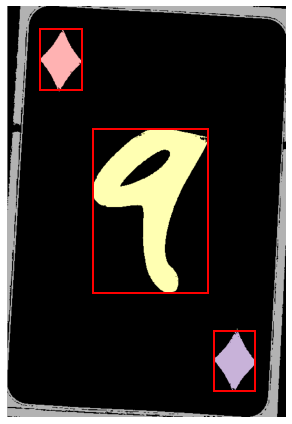

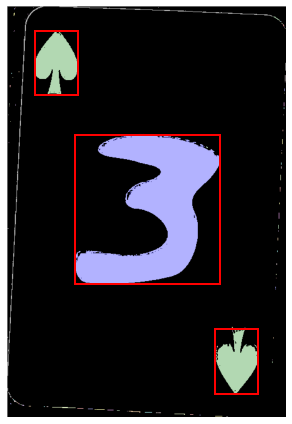

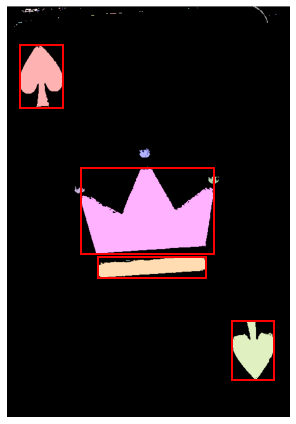

In [30]:
num_p1, boxes_p1 = find_bbox(bin_cards[0], 2000)
num_p2, boxes_p2 = find_bbox(bin_cards[1], 2000)
num_p3, boxes_p3 = find_bbox(bin_cards[2], 2000)
num_p4, boxes_p4 = find_bbox(bin_cards[3], 2000)

---
## SUITE EXTRACTION

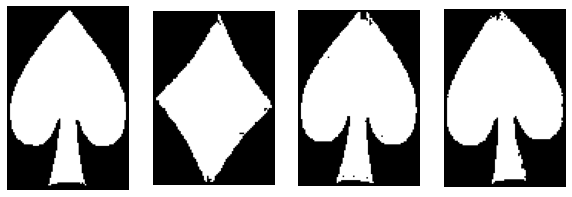

In [31]:
#Suits extraction
sx11, sy11, sx21, sy21 = boxes_p1[0][0]
suit_p1 = bin_cards[0][sx11-3:sx21+3, sy11-2:sy21+2]
sx12, sy12, sx22, sy22 = boxes_p2[0][0]
suit_p2 = bin_cards[1][sx12-2:sx22+2, sy12-2:sy22+2]
sx13, sy13, sx23, sy23 = boxes_p3[0][0]
suit_p3 = bin_cards[2][sx13-2:sx23+2, sy13-2:sy23+2]
sx14, sy14, sx24, sy24 = boxes_p4[0][0]
suit_p4 =bin_cards[3][sx14-2:sx24+2, sy14-2:sy24+2]

suits = [suit_p1, suit_p2, suit_p3, suit_p4]
plot_cards(suits, 'gray')

## Ranks and suites extraction functions

In order to extract the rank and the suite of a card, we must differentiate them. We observe that the box for the rank is bigger than the ones for the suite. We store the biggest box as the rank by applying a threshold in case if the biggest box is the card itself. For the suites, we must rotate the second one, as it is upside down. If we find 2 suites, we store them, otherwise we need to filter the boxes to only keep 2 of them (it happens sometimes when we detect a King : we get 2 boxes for the King symbol). In the end we only need one of the suites for the classification, but we still try to get two 'suites' because one of them might be some artifact on the image detected as a suite. The way our bbox algorithm works, the second bbox he detects for the suite is less often an artefact than the first one, so we use the second one for the classification.

We should then perform binary morphology on them to make them clearer.

### SUITE EXTRACTION FUNCTIONS

In [32]:
from skimage.transform import resize

def extraction(cards, bplot=False):
    
    # 0: Player1, 1: Player2 etc...
    # Each image has two images of its suit. We store both as list [suit1, suit2]
    extracted_suites = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    
    # Was (300, 300) for creating training set
    size_suite1 = (300, 300)
    size_suite2 = (28, 28)
    
    # We have to use empty arrays instead of None because we directly store the images of the digits
    extracted_ranks = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    size_rank = (28, 28) # Same size as MNIST images
    
    for i in range(4):
        if cards[i].size!=0:
            
            # Remove holes inside object
            card = card_morpho(cards[i])
            
            # Find bbox of objects on card
            num, boxes = find_bbox(card, 2000, bplot)
            
            # Get suits + digit bboxes
            rank, suite = get_suit_rank(boxes)
            
            # Get shape of card
            height, width = card.shape
            
            dx1, dy1, dx2, dy2 = suite[0]

            # Check that we don't select out of bounds of the image
            incr = 5
            if (dx1-incr > 0) & (dx2 + incr < height) & (dy1-incr > 0) & (dy2+incr < width):
                dx1 -= incr
                dx2 += incr
                dy1 -= incr
                dy2 += incr

            ## Check not out of bounds
            # Mathematical morphology
            im_suite = suite_morpho(card[dx1:dx2, dy1:dy2])
            im_suite = resize(im_suite, size_suite1)
            
            # Add padding
            padding = ((40, 40), (40, 40))
            im_suite_padded = np.pad(im_suite, padding, 'constant', constant_values=0)
            
            # Add suite of image i to extracted_suites
            extracted_suites[i] = resize(im_suite, size_suite2)
            
            # Get image of rank
            dx1, dy1, dx2, dy2 = rank[0]
            
            # Check that we don't select out of bounds of the image
            incr = 60
            if (dx1-incr > 0) & (dx2 + incr < height) & (dy1-incr > 0) & (dy2+incr < width):
                dx1 -= incr
                dx2 += incr
                dy1 -= incr
                dy2 += incr
            
            # Mathematical morphology
            im_rank = rank_morpho(card[dx1:dx2, dy1:dy2])
            im_rank = resize(im_rank, size_rank)
            
            extracted_ranks[i] = im_rank
            
    return extracted_ranks, extracted_suites

def get_suit_rank(bboxes):
    # Labels bboxes as suit or rank
    
    num_bboxes = len(bboxes.keys())
    
    # Store bbox areas
    areas = np.empty(num_bboxes)
    
    for i in range(num_bboxes):
        # Sometimes card is detected, we don't keep it
        if bboxes[i][1] > 80000:
            areas[i] = -1
        else:
            areas[i] = bboxes[i][1]
        
    # Biggest area is that of digit bbox
    idx_rank = np.argmax(areas)
    
    rank = bboxes[idx_rank]
    
    suites = [bboxes[i] for i in bboxes.keys() if ((i!=idx_rank) & (areas[i]>0))]
    
    len_suites = len(suites)
    
    # If we have found 2 suites or less return first one
    if len_suites <= 2:
        return rank, suites[0]
    
    # Otherwise need to filter to keep 2. Happens when we detect a king (2 bboxes for the king symbol)
    # Merge detected suite closer to the rank as part of the rank (it's small rectangle below king)
    # We return second suite in list only because it is most often the correct suite and not an artifact
    else:
        distances = np.empty(len_suites)
        
        for i in range(len_suites):
            distances[i] = compute_distance(rank[2][0], rank[2][1], suites[i][2][0], suites[i][2][1])
        
        # Get index of smallest distance
        idx_min = np.argmin(distances)
        
        # Merge bbox with the rank if close enough
        # We make assumption that bbox to merge is below the rank (i.e small rectangle of king)
        if distances[idx_min] < 100:
            rx1, ry1, rx2, ry2 = rank[0]
            cx1, cy1, cx2, cy2 = suites[idx_min][0]
            rank = ([rx1-18, ry1, cx2, ry2], bboxes[idx_rank][1], bboxes[idx_rank][2])
            suites_ = [suites[i] for i in range(len_suites) if (i!=idx_min)]
            
        # If it wasn't close enough, we picked up a "suite" that is not a suite
        # We make the assumption that this "suite" is an artifact that belongs to the borders of the cards
        # Thus the true suites are two closest from rank
        else:
            
            suites_ = [suites[idx_min]]
            distances[idx_min] = np.float('inf')
            suites_.append(suites[np.argmin(distances)])
            
        return rank, suites_[1]

In [33]:
from skimage.morphology import opening, disk

def suite_morpho(suite):
    
    im_suite = closing(suite, square(2))
    im_suite = opening(im_suite, disk(2))
    
    return im_suite

def rank_morpho(rank):
    
    im_rank = closing(rank, disk(2))
    im_rank = opening(im_rank, disk(4))
    
    return im_rank

def card_morpho(card):
    
    im_card = closing(card, disk(3))
    
    return im_card

In [34]:
ranks, suites = extraction(cards_rotated)

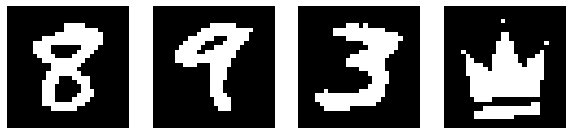

In [35]:
plot_cards(ranks, 'gray')

In [36]:
def plot_suites(suites, cmap='gray'):

    fig, ax = plt.subplots(2, 4, figsize=(10, 5))
    
    for i in range(4):
        if suites[i]!=None:
            for j in range(len(suites[i])):
                ax[j][i].imshow(suites[i][j], cmap=cmap)
        ax[0][i].axis('off')
        ax[1][i].axis('off')

    plt.show()

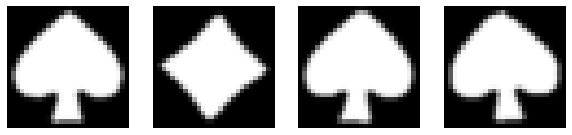

In [37]:
plot_cards(suites, 'gray')

In [38]:
def round_to_elems(img, bplot=False):
    ## From the image of a round, returns the images of the ranks, suites and the dealer
    
    image_cropped = crop(img)

    #decompose channels
    images = decompose_channels(image_cropped)

    #normalize the 4 channels
    binaries = [] 
    for i in range(len(images)):
        binaries.append(norm_binary(images[i]))

    #boxes on blue channel
    num, bboxes = find_bbox(binaries[3], plot=False)

    #rearrange boxes
    threshold = 100
    num, bboxes = remove_dup_bboxes(num, bboxes, threshold)
    boxes = rearrange_boxes(bboxes)
    
    dealer = find_dealer(find_distances(boxes))

    #extract cards
    cards = extract_cards(image_cropped, boxes)

    #rotate cards
    cards_rotated = rotate_cards(cards)
    bin_cards = binarize_cards(cards_rotated)

    #ranks and suites extraction
    ranks, suites = extraction(bin_cards, bplot)
    
    return ranks, suites, dealer

---
## Training set

In order to build our training set for classification, we first extract all of the ranks and suites of all of the given games, except for the first round of each game that we will use to test our model. We convert them into arrays, and we save them with their respective labels.

Then we load them back and remove the incorrect images. We check all the ranks (and digits) and suites to see if they are correct : we had to flip one Jack from the ranges and we had to remove multiple suites that could mislead our training. We double-checked if everything was correct and we saved the training set. 

#### Extracting all ranks and suites

In [39]:
import re
import pickle
import pandas as pd

data_base_path = os.path.join(os.pardir, 'project/train_games')
save_folder = "train_set/"

# Only include JQK
ranks_im = []
ranks_label = []

suites_im = []
suites_label = []

for root, dirs, files in os.walk(data_base_path):
    
    m = re.search(r'game(\d+$)', root)
    name_game = ''
    if m:
        name_game = m.group(0)
        df_csv = pd.read_csv((root+'/'+name_game+'.csv'))
        print(name_game)
    
    for i in range(len(files)-1):
        if files[i].endswith(".jpg"):
            
            m2 = re.search(r'(\d+)', files[i])
            num_round = None
            if m2:
                num_round = m2.group(0)
            
            # Find the round number
            
            file_im = num_round+".jpg"

            img = skimage.io.imread(os.path.join(root, files[i]))
            
            ranks, suites, _ = round_to_elems(img)
            
            for idx_player in range(4):
                label_im = df_csv.iloc[int(num_round)-1, idx_player+1]
                label_rank = label_im[0]
                label_suite = label_im[1]
            
                if (ranks[idx_player].size!=0):
                    ranks_im.append(ranks[idx_player].flatten())
                    ranks_label.append(label_rank)
                
                if (suites[idx_player].size!=0):
                    
                    suites_im.append((suites[idx_player].flatten()))
                    suites_label.append(label_suite)
                        

game5
game2
game3
game4
game1
game6
game7


In [40]:
# Convert ranks_im and suites_im to numpy arrays
ranks_im = np.asarray(ranks_im)
suites_im = np.asarray(suites_im)

# Save ranks_im + ranks_label
np.save(save_folder+'ranks_im.npy', ranks_im)
with open(save_folder+"ranks_label.txt", "wb") as fp:   #Pickling
    pickle.dump(ranks_label, fp)
    
# Save suites_im + suites_label
np.save(save_folder+'suites_im.npy', suites_im)
with open(save_folder+"suites_label.txt", "wb") as fp2:   #Pickling
    pickle.dump(suites_label, fp2)

#### Open back files and remove incorrect images

In [41]:
import pickle
# Open rank files
ranks_images = np.load(save_folder+'ranks_im.npy')
with open(save_folder+"ranks_label.txt", "rb") as fp:   # Unpickling
    ranks_label_op = pickle.load(fp)

# Open suite files
suites_images = np.load(save_folder+'suites_im.npy')
with open(save_folder+"suites_label.txt", "rb") as fp2:   # Unpickling
    suites_label_op = pickle.load(fp2)

##### Check rank images

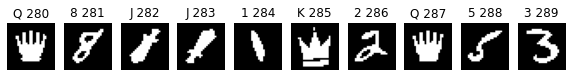

In [42]:
ranks_shape = (28, 28)

fig, ax = plt.subplots(1, 10, figsize = (10,10))

start = 280
end = start + 10
idx = 0
for i in range(start, end):
    ax[idx].imshow(ranks_images[i].reshape(ranks_shape), cmap='gray')
    ax[idx].set_title(ranks_label_op[i] + " "+ str(i))
    ax[idx].axis('off')
    idx += 1

idx to remove: 143, 247, 258
<br> idx to flip: 266, 282

In [43]:
# First we flip
ranks_images[266] = imutils.rotate(ranks_images[55].reshape(ranks_shape), 180).flatten()
ranks_images[282] = imutils.rotate(ranks_images[61].reshape(ranks_shape), 180).flatten()

In [44]:
idx_remove = [143, 247, 258]
new_ranks_im = []
new_ranks_labels = []

for i in range(len(ranks_label_op)):
    if i not in idx_remove:
        new_ranks_im.append(ranks_images[i])
        new_ranks_labels.append(ranks_label_op[i])

new_ranks_images = np.asarray(new_ranks_im)

We can save the images of the ranks again.

In [45]:
np.save(save_folder+'ranks_im.npy', new_ranks_images)
with open(save_folder+"ranks_label.txt", "wb") as fp:   #Pickling
    pickle.dump(new_ranks_labels, fp)

##### Check suite images

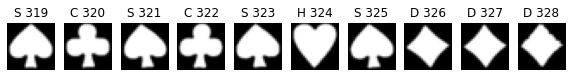

In [46]:
suites_shape = (28, 28)

fig, ax = plt.subplots(1, 10, figsize = (10,12))

start = 319
end = start + 10
idx = 0
for i in range(start, end):
    ax[idx].imshow(suites_images[i].reshape(suites_shape), cmap='gray')
    ax[idx].set_title(suites_label_op[i] + " "+ str(i))
    ax[idx].axis('off')
    idx += 1

idx to remove : 129, 248
<br> idx to flip : 80, 143, 155, 255, 266, 271

In [47]:
idx_remove = [129, 248]

idx_flip = [80, 143, 155, 255, 266, 271]

# First flip images to flip
for idx in idx_flip:
    suites_images[idx] = imutils.rotate(suites_images[idx].reshape(suites_shape), 180).flatten()

In [48]:
# Remove images and labels
new_suites_im = []
new_suites_labels = []

for i in range(len(suites_label_op)):
    if i not in idx_remove:
        new_suites_im.append(suites_images[i])
        new_suites_labels.append(suites_label_op[i])

new_suites_images = np.asarray(new_suites_im)

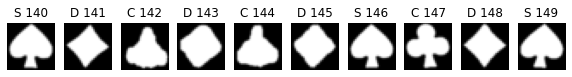

In [49]:
# Check correct changes

fig, ax = plt.subplots(1, 10, figsize = (10,12))

start = 140
end = start + 10
idx = 0
for i in range(start, end):
    ax[idx].imshow(new_suites_images[i].reshape(suites_shape), cmap='gray')
    ax[idx].set_title(new_suites_labels[i] + " "+ str(i))
    ax[idx].axis('off')
    idx += 1

We can save the changes

In [50]:
# Save suites_im + suites_label
np.save(save_folder+'suites_im.npy', new_suites_images)
with open(save_folder+"suites_label.txt", "wb") as fp2:   #Pickling
    pickle.dump(new_suites_labels, fp2)